In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, Action_Scheduler, DQN
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.envs._state import TractographyState

class Object(object):
    pass

In [2]:
# Test on Lunar Lander to check functionality of agent
#env = gym.make('LunarLander-v2')
#n_actions= env.action_space.n

In [2]:
max_steps = 30000000
replay_memory_size = 60000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 10000
start_learning = 20000
eps_annealing_steps = 10000000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
learning_rate = 0.0000000625
#batch_size = 512
#learning_rate = 0.001

In [ ]:
env = RLTe.RLtractEnvironment(stepWidth=0.1, action_space=20, device = 'cpu')
#env = RLTe.RLtractEnvironment(stepWidth=0.3, action_space=20, device = 'cpu', pReferenceStreamlines='data/HCP307200_DTI_min40.vtk')
n_actions = env.action_space.n

Loading precomputed streamlines (data/HCP307200_DTI_smallSet.vtk) for ID 100307


In [ ]:
state = env.reset()
print(state)
#print(state.getValue().flatten().shape)

In [ ]:
state = env.reset(streamline_index=0)
#env.stepCounter += 1
#state = env.state = TractographyState(env.referenceStreamline_ijk[1], env.interpolateDWIatState)
best_actions = []
    #path_vectors = []
    #reference_vectors = []
    #cosine_sims = []
    #distances = []
rewards = []
all_states = []
all_states.append(state.getCoordinate())
for i in range(n_actions):
    #print(state.getCoordinate(), env.state.getCoordinate())
    #print(env.stepCounter)
    next_state, reward,_,_ = env.step(i)
    all_states.append(next_state.getCoordinate())
    all_states.append(state.getCoordinate())
    rewards.append(reward)
    #print(reward)
    best_actions.append(reward)
    env.state = state
    env.stepCounter -= 1
best_action= torch.argmax(torch.tensor(best_actions))
#return best_action, rewards[best_action]
print(best_action, float(rewards[best_action]))
#print(np.argmin(rewards))


In [3]:
env = RLTe.RLtractEnvironment(stepWidth=0.1, action_space=20, maxL2dist_to_State=0.1, device = 'cpu')

def get_best_action(state, env):
    distances = []
    points_before = env.points_visited
    for i in range(n_actions):
        next_state, reward,_, _ = env.step(i)
        env.stepCounter -= 1
        if env.points_visited > points_before:
            env.points_visited = points_before
        del env.state_history[-1]
        distances.append(env.l2_distance)
        env.state = state
        

    best_action= np.argmin(distances)
    return best_action, distances[best_action]

Loading precomputed streamlines (data/HCP307200_DTI_smallSet.vtk) for ID 100307


In [4]:
n_actions = env.action_space.n

In [5]:
state = env.reset(streamline_index=0)
all_top_actions = []
all_top_rewards = []
terminal = False

states = Object()
states.x = [state.getCoordinate()[0]]
states.y = [state.getCoordinate()[1]]
states.z = [state.getCoordinate()[2]]
i = 0
while (terminal != True) and (i < 1000):
    best_actions, best_rewards = get_best_action(state, env)
    all_top_actions.append(best_actions)
    all_top_rewards.append(best_rewards)
    next_state, reward, terminal, _ = env.step(best_actions)
    state = next_state
    if reward == 1:
        print("Reached point {}/{} at epsiode step {}".format(env.points_visited, len(env.referenceStreamline_ijk), env.stepCounter))
    #print(best_actions, best_rewards, env.points_visited)
    i += 1
    #print(i)
    states.x.append(state.getCoordinate()[0])
    states.y.append(state.getCoordinate()[1])
    states.z.append(state.getCoordinate()[2])

Reached point 2/87 at epsiode step 10
Reached point 3/87 at epsiode step 20
Reached point 4/87 at epsiode step 31
Reached point 5/87 at epsiode step 41
Reached point 6/87 at epsiode step 52
Reached point 7/87 at epsiode step 62
Reached point 8/87 at epsiode step 72
Reached point 9/87 at epsiode step 82
Reached point 10/87 at epsiode step 92
Reached point 11/87 at epsiode step 102
Reached point 12/87 at epsiode step 112
Reached point 13/87 at epsiode step 120
Reached point 14/87 at epsiode step 129
Reached point 15/87 at epsiode step 139
Reached point 16/87 at epsiode step 148
Reached point 17/87 at epsiode step 157
Reached point 18/87 at epsiode step 165
Reached point 19/87 at epsiode step 174
Reached point 20/87 at epsiode step 183
Reached point 21/87 at epsiode step 191
Reached point 22/87 at epsiode step 200
Reached point 23/87 at epsiode step 208
Reached point 24/87 at epsiode step 216
Reached point 25/87 at epsiode step 224
Reached point 26/87 at epsiode step 233
Reached point 27/

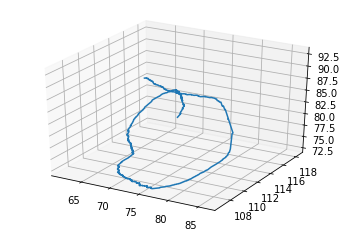

In [19]:
import matplotlib.pyplot as plt
no_timesteps = 3
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot3D(env.referenceStreamline_ijk.T[0][0:no_timesteps], env.referenceStreamline_ijk.T[1][0:no_timesteps], env.referenceStreamline_ijk.T[2][0:no_timesteps])
ax.plot3D(states.x, states.y, states.z)
plt.show()

### Transfer learning
Fill replay memory with perfect actions for supervised approach

In [ ]:
action, _ = get_best_action(state,env)
next_state, reward, terminal, _ = env.step(action)

In [ ]:
from dfibert.tracker import StreamlinesFromFileTracker

file_sl = StreamlinesFromFileTracker(env.pReferenceStreamlines)
file_sl.track()

tracked_streamlines = file_sl.get_streamlines()

In [7]:
from tqdm import trange
state = env.reset().getValue()
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)

overall_runs = 0
overall_reward = []
for overall_runs in trange(15):
    state = env.reset(streamline_index=overall_runs)
    episode_reward = 0
    terminal = False
    for i in range(1000):#while not terminal:
        action, _ = get_best_action(state,env)
        next_state, reward, terminal, _ = env.step(action)
            
        agent.replay_memory.add_experience(action=action,
                                state = state.getValue(),
                                reward=reward,
                                new_state = next_state.getValue(),
                                terminal=terminal)
        
        episode_reward += reward
        
        state = next_state
        
        if terminal == True:
            break
            
    overall_runs += 1
    overall_reward.append(episode_reward)
    print(overall_runs, np.mean(overall_reward[-100:]))
print("Replay memory ready")

  7%|▋         | 1/15 [01:38<22:55, 98.28s/it]

Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
1 86.0


 13%|█▎        | 2/15 [02:39<18:54, 87.27s/it]

Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
2 71.5


 20%|██        | 3/15 [04:39<19:25, 97.11s/it]

3 85.0


 27%|██▋       | 4/15 [05:57<16:44, 91.32s/it]

Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
4 81.25


 33%|███▎      | 5/15 [06:44<13:29, 80.98s/it]

Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
5 73.4


IndexError: list index out of range

In [ ]:
#save memory
import h5py
hf = h5py.File('memory_dti.hdf5', 'w')
hf.create_dataset('states', data=agent.replay_memory.states[:agent.replay_memory.count])
hf.create_dataset('new_states', data=agent.replay_memory.new_states[:agent.replay_memory.count])
hf.create_dataset('actions', data=agent.replay_memory.actions[:agent.replay_memory.count])
hf.create_dataset('rewards', data=agent.replay_memory.rewards[:agent.replay_memory.count])
hf.create_dataset('terminals', data=agent.replay_memory.terminal_flags[:agent.replay_memory.count])
hf.close()


In [ ]:
#load memory
#state = #env.reset().getValue()
agent_learn = Agent(n_actions=20, inp_size=(642, 3, 3, 3), device=device, hidden=10, gamma=0.95, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)
hf = h5py.File('memory_dti.hdf5', 'r')
agent_learn.replay_memory.states = np.array(hf["states"][:60000])
agent_learn.replay_memory.new_states = np.array(hf["new_states"][:60000])
agent_learn.replay_memory.actions = np.array(hf["actions"][:60000])
agent_learn.replay_memory.rewards = np.array(hf["rewards"][:60000])
agent_learn.replay_memory.terminal_flags = np.array(hf["terminals"][:60000])
hf.close()

In [ ]:
print(agent_learn.replay_memory.states.shape)

In [ ]:
agent_learn.replay_memory.count = 60000

In [ ]:
agent_learn = Agent(n_actions=101, inp_size=(100, 3, 3, 3), device=device, hidden=10, gamma=0.95, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)
hf = h5py.File('memory_dti.hdf5', 'r')
agent_learn.replay_memory.states = np.array(hf["states"][:])
agent_learn.replay_memory.new_states = np.array(hf["new_states"][:])
agent_learn.replay_memory.actions = np.array(hf["actions"][:])
agent_learn.replay_memory.rewards = np.array(hf["rewards"][:])
agent_learn.replay_memory.terminal_flags = np.array(hf["terminals"][:])
print(agent_learn.replay_memory.states.shape)

In [ ]:
agent_learn.replay_memory.rewards[10]

In [ ]:
agent_learn.replay_memory.count = 30000

In [8]:
agent.optimizer = torch.optim.Adam(agent.main_dqn.parameters(), 0.0001)

In [9]:
#### Supervised learning on perfect memory --> worked

#state = env.reset().getValue()
#agent_learn = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=64, learning_rate=0.00001)
losses = []

with trange(50000, unit="epochs") as pbar:
    for i in pbar:
    
        states, actions, _, _, _ = agent.replay_memory.get_minibatch()

        states = torch.FloatTensor(states).to(agent.device)
        actions = torch.LongTensor(actions).to(agent.device)

        predicted_q = agent.main_dqn(states)
        loss = torch.nn.functional.cross_entropy(predicted_q, actions)
        #print(loss.item())
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step()
        losses.append(loss.item())

        pbar.set_postfix(loss=loss.item())

100%|██████████| 50000/50000 [06:54<00:00, 120.54epochs/s, loss=0.225]


In [10]:
mean_losses = []
for i in range(len(losses)):
    mean_losses.append(np.mean(losses[i:i+99]))
print(mean_losses[-20:])

[0.2688422180712223, 0.2677806200165498, 0.2674466148018837, 0.2663012734230827, 0.26788164488971233, 0.2698832035064697, 0.27360816087041584, 0.2732531795134911, 0.27654164160291356, 0.27369105138561944, 0.275684954226017, 0.27095557749271393, 0.2722139451652765, 0.2646679473774774, 0.26812829325596493, 0.25447799265384674, 0.26754165440797806, 0.2501937250296275, 0.28506603837013245, 0.22472885251045227]


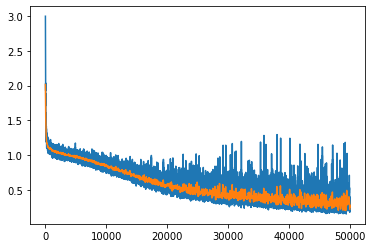

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(range(len(losses[:])), losses[:])
plt.plot(range(len(losses[:])), mean_losses[:])
plt.show()

In [ ]:
agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())

In [14]:
states, actions, _, _, _ = agent.replay_memory.get_minibatch()
states = torch.FloatTensor(states).to(agent.device)
predicted_q = torch.argmax(agent.main_dqn(states), dim=1)

false = 0
for i in range(len(actions)):
    if predicted_q[i] != actions[i]:
        false += 1 
    
print("Accuracy =", 1 - false / len(actions))

Accuracy = 0.828125


In [18]:
#### test performance of pretrained agent

state = env.reset(streamline_index=0)
terminal = False
all_states = []
all_states.append(state.getCoordinate())


states = Object()
states.x = [state.getCoordinate()[0]]
states.y = [state.getCoordinate()[1]]
states.z = [state.getCoordinate()[2]]

while not terminal:
    action = torch.argmax(agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)))
    next_state, reward, terminal, _ = env.step(action)
    #if reward < 0.:
    #
    #if reward == 0. and env.l2_distance < 0.5:
    #    reward = 1.
    #    env.points_visited += 1
    print("Reward {} at step {}, points reached {}, l2 distance {}".format(reward, env.stepCounter, env.points_visited, env.l2_distance))
    
    episode_reward += reward
    all_states.append(next_state.getCoordinate())
    state = next_state
    
    
    states.x.append(state.getCoordinate()[0])
    states.y.append(state.getCoordinate()[1])
    states.z.append(state.getCoordinate()[2])
    
    print("Episode finished with {} reward".format(episode_reward))
    
    #print(env.stepCounter, action, reward)#cosine_sim.item(), dist.item(), 1-(optimal_reward-(cosine_sim-dist)))
    #if action == 100 and 1-(optimal_reward-(cosine_sim-dist)) == 1:
    #    terminal = True
    #else:
    #    terminal = False
    

Reward 0.0 at step 1, points reached 1, l2 distance 0.7191250262328941
Episode finished with 42.0 reward
Reward 0.0 at step 2, points reached 1, l2 distance 0.6436396269863729
Episode finished with 42.0 reward
Reward 0.0 at step 3, points reached 1, l2 distance 0.5756762419102027
Episode finished with 42.0 reward
Reward 0.0 at step 4, points reached 1, l2 distance 0.4927653645843112
Episode finished with 42.0 reward
Reward 0.0 at step 5, points reached 1, l2 distance 0.42753878680189744
Episode finished with 42.0 reward
Reward 0.0 at step 6, points reached 1, l2 distance 0.37783743052557384
Episode finished with 42.0 reward
Reward 0.0 at step 7, points reached 1, l2 distance 0.28258941977201696
Episode finished with 42.0 reward
Reward 0.0 at step 8, points reached 1, l2 distance 0.19223016523948988
Episode finished with 42.0 reward
Reward 0.0 at step 9, points reached 1, l2 distance 0.15035036860944173
Episode finished with 42.0 reward
Reward 1.0 at step 10, points reached 2, l2 distan

Reward -1.0 at step 104, points reached 5, l2 distance 4.1062752364090445
Episode finished with 25.0 reward
Reward -1.0 at step 105, points reached 5, l2 distance 4.199060521522873
Episode finished with 24.0 reward
Reward -1.0 at step 106, points reached 5, l2 distance 4.273419775096057
Episode finished with 23.0 reward
Reward -1.0 at step 107, points reached 5, l2 distance 4.366232045400785
Episode finished with 22.0 reward
Reward -1.0 at step 108, points reached 5, l2 distance 4.441310880685084
Episode finished with 21.0 reward
Reward -1.0 at step 109, points reached 5, l2 distance 4.534132860077139
Episode finished with 20.0 reward
Reward -1.0 at step 110, points reached 5, l2 distance 4.609866984119519
Episode finished with 19.0 reward
Reward -1.0 at step 111, points reached 5, l2 distance 4.680830382204586
Episode finished with 18.0 reward
Reward -1.0 at step 112, points reached 5, l2 distance 4.743029440761574
Episode finished with 17.0 reward
Reward -1.0 at step 113, points reac

Reward -1.0 at step 194, points reached 5, l2 distance 11.508472234957944
Episode finished with -65.0 reward
Reward -1.0 at step 195, points reached 5, l2 distance 11.599381607334633
Episode finished with -66.0 reward
Reward -1.0 at step 196, points reached 5, l2 distance 11.690439434099478
Episode finished with -67.0 reward
Reward -1.0 at step 197, points reached 5, l2 distance 11.781642273135066
Episode finished with -68.0 reward
Reward -1.0 at step 198, points reached 5, l2 distance 11.872986782688605
Episode finished with -69.0 reward
Reward -1.0 at step 199, points reached 5, l2 distance 11.964469717947111
Episode finished with -70.0 reward
Reward -1.0 at step 200, points reached 5, l2 distance 12.056087927742087
Episode finished with -71.0 reward
Reward -1.0 at step 201, points reached 5, l2 distance 12.056268904271334
Episode finished with -72.0 reward
Reward -1.0 at step 202, points reached 5, l2 distance 12.057279281112772
Episode finished with -73.0 reward
Reward -1.0 at step

Reward -1.0 at step 284, points reached 5, l2 distance 16.19345433752477
Episode finished with -155.0 reward
Reward -1.0 at step 285, points reached 5, l2 distance 16.18660242240053
Episode finished with -156.0 reward
Reward -1.0 at step 286, points reached 5, l2 distance 16.23906137860416
Episode finished with -157.0 reward
Reward -1.0 at step 287, points reached 5, l2 distance 16.29196522630968
Episode finished with -158.0 reward
Reward -1.0 at step 288, points reached 5, l2 distance 16.34530964565965
Episode finished with -159.0 reward
Reward -1.0 at step 289, points reached 5, l2 distance 16.399090337262766
Episode finished with -160.0 reward
Reward -1.0 at step 290, points reached 5, l2 distance 16.394894708424825
Episode finished with -161.0 reward
Reward -1.0 at step 291, points reached 5, l2 distance 16.44960964522757
Episode finished with -162.0 reward
Reward -1.0 at step 292, points reached 5, l2 distance 16.504749088077396
Episode finished with -163.0 reward
Reward -1.0 at s

Reward -1.0 at step 374, points reached 5, l2 distance 19.270530472956562
Episode finished with -245.0 reward
Reward -1.0 at step 375, points reached 5, l2 distance 19.30748792439736
Episode finished with -246.0 reward
Reward -1.0 at step 376, points reached 5, l2 distance 19.34489170795102
Episode finished with -247.0 reward
Reward -1.0 at step 377, points reached 5, l2 distance 19.300915369895378
Episode finished with -248.0 reward
Reward -1.0 at step 378, points reached 5, l2 distance 19.21505526849955
Episode finished with -249.0 reward
Reward -1.0 at step 379, points reached 5, l2 distance 19.253246402256856
Episode finished with -250.0 reward
Reward -1.0 at step 380, points reached 5, l2 distance 19.291880288881664
Episode finished with -251.0 reward
Reward -1.0 at step 381, points reached 5, l2 distance 19.33095427378238
Episode finished with -252.0 reward
Reward -1.0 at step 382, points reached 5, l2 distance 19.37046569366853
Episode finished with -253.0 reward
Reward -1.0 at 

Reward -1.0 at step 464, points reached 5, l2 distance 20.381442387483375
Episode finished with -335.0 reward
Reward -1.0 at step 465, points reached 5, l2 distance 20.3164566123538
Episode finished with -336.0 reward
Reward -1.0 at step 466, points reached 5, l2 distance 20.381605072709036
Episode finished with -337.0 reward
Reward -1.0 at step 467, points reached 5, l2 distance 20.317181924933454
Episode finished with -338.0 reward
Reward -1.0 at step 468, points reached 5, l2 distance 20.3346158297172
Episode finished with -339.0 reward
Reward -1.0 at step 469, points reached 5, l2 distance 20.40039453756382
Episode finished with -340.0 reward
Reward -1.0 at step 470, points reached 5, l2 distance 20.33669269289194
Episode finished with -341.0 reward
Reward -1.0 at step 471, points reached 5, l2 distance 20.403024446753385
Episode finished with -342.0 reward
Reward -1.0 at step 472, points reached 5, l2 distance 20.33989231818326
Episode finished with -343.0 reward
Reward -1.0 at st

Reward -1.0 at step 552, points reached 5, l2 distance 22.558569861658146
Episode finished with -423.0 reward
Reward -1.0 at step 553, points reached 5, l2 distance 22.632878672842686
Episode finished with -424.0 reward
Reward -1.0 at step 554, points reached 5, l2 distance 22.63069357253795
Episode finished with -425.0 reward
Reward -1.0 at step 555, points reached 5, l2 distance 22.705219150224583
Episode finished with -426.0 reward
Reward -1.0 at step 556, points reached 5, l2 distance 22.703493860715067
Episode finished with -427.0 reward
Reward -1.0 at step 557, points reached 5, l2 distance 22.657871936587274
Episode finished with -428.0 reward
Reward -1.0 at step 558, points reached 5, l2 distance 22.732823154930095
Episode finished with -429.0 reward
Reward -1.0 at step 559, points reached 5, l2 distance 22.73179878753367
Episode finished with -430.0 reward
Reward -1.0 at step 560, points reached 5, l2 distance 22.80695784809457
Episode finished with -431.0 reward
Reward -1.0 a

Reward -1.0 at step 642, points reached 5, l2 distance 23.02274306332596
Episode finished with -513.0 reward
Reward -1.0 at step 643, points reached 5, l2 distance 22.953704180284713
Episode finished with -514.0 reward
Reward -1.0 at step 644, points reached 5, l2 distance 22.976020957931603
Episode finished with -515.0 reward
Reward -1.0 at step 645, points reached 5, l2 distance 22.90748089192759
Episode finished with -516.0 reward
Reward -1.0 at step 646, points reached 5, l2 distance 22.93048164770943
Episode finished with -517.0 reward
Reward -1.0 at step 647, points reached 5, l2 distance 22.850470915068303
Episode finished with -518.0 reward
Reward -1.0 at step 648, points reached 5, l2 distance 22.770618206030903
Episode finished with -519.0 reward
Reward -1.0 at step 649, points reached 5, l2 distance 22.69092518892232
Episode finished with -520.0 reward
Reward -1.0 at step 650, points reached 5, l2 distance 22.611393552227444
Episode finished with -521.0 reward
Reward -1.0 at

Reward -1.0 at step 732, points reached 5, l2 distance 17.093267216307275
Episode finished with -603.0 reward
Reward -1.0 at step 733, points reached 5, l2 distance 17.024279311411416
Episode finished with -604.0 reward
Reward -1.0 at step 734, points reached 5, l2 distance 16.95560049121872
Episode finished with -605.0 reward
Reward -1.0 at step 735, points reached 5, l2 distance 16.87948044479576
Episode finished with -606.0 reward
Reward -1.0 at step 736, points reached 5, l2 distance 16.803610688023824
Episode finished with -607.0 reward
Reward -1.0 at step 737, points reached 5, l2 distance 16.734936916164806
Episode finished with -608.0 reward
Reward -1.0 at step 738, points reached 5, l2 distance 16.65916640773728
Episode finished with -609.0 reward
Reward -1.0 at step 739, points reached 5, l2 distance 16.59065539929843
Episode finished with -610.0 reward
Reward -1.0 at step 740, points reached 5, l2 distance 16.514987076445973
Episode finished with -611.0 reward
Reward -1.0 at

# Validation of our agent

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

#for i in range(len(states)):
#    print(states[i], env.referenceStreamline_ijk[i])
#    distance = ((states.T[0][i] - env.referenceStreamline_ijk.T[0][i])**2 \
#                      + (states.T[1][i] - env.referenceStreamline_ijk.T[1][i] )**2 \
#                      + (states.T[2][i] - env.referenceStreamline_ijk.T[2][i])**2)
#    print(distance)
no_timesteps = 5

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][0:no_timesteps], env.referenceStreamline_ijk.T[1][0:no_timesteps], env.referenceStreamline_ijk.T[2][0:no_timesteps])
ax.plot3D(states.x, states.y, states.z)
#plt.legend('gt','agent')
#print(optimal_steps[:])

In [ ]:
len(all_states)

In [ ]:
state = env.reset().getValue()
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)

In [ ]:
agent.main_dqn.load_state_dict(torch.load("defi_pretrained_95pacc.pth"))
agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())

In [ ]:
print(state.shape)
print(agent.main_dqn)

In [ ]:
#### DQN training

#uncomment next 2 lines for regular DQN trainig without pretrained network
#state = env.reset().getValue()
#agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.95, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

#transition = init_transition()
#agent = Agent(n_actions=n_actions, inp_size=np.array(transition).shape, device=device, hidden=10, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_initial=0.5, eps_annealing_steps=eps_annealing_steps, eps_final=0.1, eps_final_step=0.02, replay_memory_start_size=start_learning, model=agent.main_dqn)

step_counter = 0

eps_rewards = []

episode_lengths = []

cos = torch.nn.CosineSimilarity(dim=0)

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0
    #agent.main_dqn.train()
######## fill memory begins here
    while (epoch_step < evaluate_every) or (step_counter < start_learning):
        state = env.reset()
        env.stepCounter = np.random.randint(len(env.referenceStreamline_ijk)-10)
        env.state = TractographyState(env.referenceStreamline_ijk[env.stepCounter], env.interpolateDWIatState)
        #transition = init_transition()
        #referenceLine = env.referenceStreamline_ijk
        episode_reward_sum = 0
        terminal = False
        #fill replay memory while interacting with env
        #for episode_counter in range(max_episode_length):
        episode_step_counter = 0
        positive_run = 0
        points_visited = 0
        
        dist = 0
        #influential_action = None
        while not terminal:
            # get action with epsilon-greedy strategy
            #if dist < 0.1:
            #_, optimal_reward = get_best_action(state, env)
               #print(influential_action)
            #else:
            #    influential_action = None
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)) #influential_action=influential_action)
            #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device))
            #print("Before step: ", env.stepCounter)
            
            next_state, reward, terminal = env.step(action)
            episode_step_counter += 1
            #print(episode_step_counter, action, reward, optimal_reward, torch.tanh(1-(optimal_reward - reward)))
            #print("After step: ", env.stepCounter)
            
            #if reward < -1.:
            #    reward = -1.
            
            #terminal = False
            
            #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
            #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
            ##    #print(path_vector, reference_vector)
            #cosine_sim = cos(path_vector, reference_vector)
            #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
            #reward = -torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
            #if reward == 0.:
            #    reward = 1.
            
            #if reward < -0.05:
            #    env.stepCounter -= 1
            
            #reward = torch.tanh(1- (optimal_reward - reward))
            #if reward >= 0.76:
            #    reward = 1.
            #elif reward < 0.:
            #    reward = -1.
            #else:
            #    reward = 0.
            current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
            dist_past = torch.dist(env.referenceStreamline_ijk[current_index], state.getCoordinate(), p=2)
            #if dist <= 0.09:
            #    reward = 1.
            #elif dist < 0.25:
            #    reward = 0.5
            #elif dist < 1.:
            #    reward = 0.25
            #elif dist_past < dist:
            #    reward = -1
            #    #env.stepCounter -= 1
            #else:
            #    reward = 0.
                #env.stepCounter -= 1
            
            #if action == 19:
            #    if dist <= 0.09:
            #        reward = 1.
            #    else:
            #        reward = -1.
                    
            #if reward > 0.:
            #    positive_run += 1
            #print("Before test for dist: ", env.stepCounter, "Dist: ", dist)
            #print("After test for dist: ", env.stepCounter)
            #if dist < dist_past:
            reward = 0.
                #positive_run += 1 
            if dist > 2.:
                reward = -1.
                
            if dist > 0.25:
                env.stepCounter -= 1
                #if dist < dist_past:
                    #reward = 0.5
                    #positive_run += 1
            else:
                points_visited += 1
                reward = 1.
                positive_run += 1
                print("Reached referencePoint {} at step {}".format(points_visited, episode_step_counter))
                #env.stepCounter -= 1
            #if reward < -5.0:
            #    reward = -5.0
            #if reward < -100:
            #    reward = -100
            #if dist < 0.1:
            #    dist = 0
            #else:
            #    dist = dist - 0.1
            #if dist > 3*0.81:
            #    env.stepCounter -= 1
            #reward = cosine_sim - dist
            #reward = 1 - (optimal_reward - reward)
            #reward = 1- (optimal_reward - dist)
            #if reward == optimal_reward:
            #    reward = 1
            #if action == 100 and dist < 0.1:
            #    terminal = True
            #print("From function: ", influential_action, optimal_reward)
            #print("From scheduler: ", action, reward,  terminal)
            #print("Cosine sim: ", cosine_sim)
            #print("Dist: ", dist)
            
            #if episode_step_counter >= 200:
            #    terminal = True
            
            #print(episode_step_counter, action, reward, terminal)
            #print(reward)
            #if dist > 0.7: # cosine_sim < 0.4 or
            #    terminal = True
            #next_state = next_state[:2]
            #next_transition = add_to_transition(next_state, transition)
            
            step_counter += 1
            epoch_step += 1

            # accumulate reward for current episode
            episode_reward_sum += reward


            agent.replay_memory.add_experience(action=action,
                                #state=np.array(transition),
                                state = state.getValue(),
                                reward=reward,
                                #new_state=np.array(next_transition),
                                new_state = next_state.getValue(),
                                terminal=terminal)


            state = next_state
            #transition = next_transition



            ####### optimization is happening here
            if step_counter > start_learning and step_counter % 4 == 0:
                #if reward > 0.:
                #    print("reward was positive: ", reward)
                loss = agent.optimize()


            ####### target network update
            if step_counter > start_learning and step_counter % network_update_every == 0:
                #print("Update net")
                #print(agent.main_dqn(torch.tensor(state).to(device).unsqueeze(0)))
                #print(agent.target_dqn(torch.tensor(state).to(device).unsqueeze(0)))
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())

            # if episode ended before maximum step
            if episode_step_counter >= 1000:
                terminal = True
            if terminal:
                terminal = False
                episode_lengths.append(episode_step_counter)
                #state = env.reset()[:2]
                #transition = init_transition()
                break

        eps_rewards.append(episode_reward_sum)

        if len(eps_rewards) % 1 == 0:
            #with open(path+'/logs/rewards.dat', 'a') as reward_file:
                #print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])), file=reward_file)
            print("{}, done {} episodes, {}, current eps {}".format(step_counter, len(eps_rewards), np.mean(eps_rewards[-100:]), action_scheduler.eps_current), np.mean(episode_lengths[-100:]), positive_run, points_visited)
    #torch.save(agent.main_dqn.state_dict(), path+'/checkpoints/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eps_rewards[-100:])))

########## evaluation starting here
    eval_rewards = []
    episode_final = 0
    #agent.main_dqn.eval()
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        #transition = init_transition()
        #env.state = TractographyState(env.referenceStreamline_ijk[0], env.interpolateDWIatState)
        #env.stepCounter = 0
        
        eval_episode_reward = 0
        while eval_steps < 1000:
            #_, optimal_reward = get_best_action(state, env)
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device), evaluation=True)
            #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
            next_state, reward, terminal = env.step(action)
            
            eval_steps += 1
            
            #if reward < -0.05:
            #    env.stepCounter -= 1
            #reward = 1 - (optimal_reward-reward)
            #if reward >= 0.76:
            #    reward = 1
            #elif reward < 0.:
            #    reward = -1.
            #else:
            #    reward = 0.
            current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
            dist_past = torch.dist(env.referenceStreamline_ijk[current_index], state.getCoordinate(), p=2)
            
            reward = 0.
                #positive_run += 1 
            if dist > 2.:
                reward = -1.
                
            if dist > 0.25:
                env.stepCounter -= 1
                #if dist < dist_past:
                #    reward = 0.5
            else:
                points_visited += 1
                reward = 1.
                positive_run += 1
        
            #if dist < dist_past:
            #    reward = 1.
            #else:
            #    reward = -1.
            #    
            #if dist > 0.1:
            #    env.stepCounter -= 1
            #else:
            #    reward += 4    
            
            #if dist <= 0.09:
            #    reward = 1.
            #elif dist < 0.25:
            #    reward = 0.5
            #elif dist < 1.:
            #    reward = 0.25
            #elif dist_past < dist:
            #    reward = -1
                #env.stepCounter -= 1
            #else:
            #    reward = 0.
                #env.stepCounter -= 1
            
            #if action == 19:
            #    if dist <= 0.09:
            #        reward = 1.
            #    else:
            #        reward = -1.
                    
            #if reward != 1.:
            #    env.stepCounter -= 1
    

            
            #if reward < -5.0:
            #    reward = -5.0
            #if reward < -100:
            #    reward = -100

            #if reward < -1.:
            #    reward = -1.
            #terminal = False
            #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
            #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
            #    #print(path_vector, reference_vector)
            #cosine_sim = cos(path_vector, reference_vector)
            #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
            #if dist < 0.1:
            #    dist = 0
            #else:
            #    dist = dist - 0.1
            #if dist > 3*0.81:
            #    env.stepCounter -= 1
            #reward = cosine_sim - dist
            #reward = 1- (optimal_reward - reward)
            #if reward == optimal_reward:
            #    reward = 1
            #if action == 100 and env.rewardForTerminalState(next_state) < 0.1:
            #    terminal = True

            #if episode_step_counter == 200:
            #    terminal = True
            
            #if cosine_sim < 0.9:
            #    terminal = True
            
            eval_episode_reward += reward
            state = next_state
            #transition = next_transition
            if terminal:
                terminal = False
                if reward == 1.:
                    print(reward)
                    episode_final += 1
                break

        eval_rewards.append(eval_episode_reward)

    print("Evaluation score:", np.mean(eval_rewards))
    print("{} of {} episodes ended close to / at the final state.".format(episode_final, eval_runs))
    #if np.mean(eval_rewards) > 500.:
    #torch.save(agent.main_dqn.state_dict(), 'checkpoints/defi_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eval_rewards)))

In [ ]:
torch.save(agent.main_dqn.state_dict(), 'defi_pretrained_95pacc.pth')

In [ ]:
print(path_vector.shape)
print(reference_vector.shape)

In [ ]:
state = env.reset()

q_vals = agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device))
print(q_vals[0][80])

In [ ]:
defi = DQN(n_actions=n_actions, input_shape=513).to(device)
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_annealing_steps=eps_annealing_steps, eps_final=0.1, eps_final_step=0.02, replay_memory_start_size=start_learning, model=defi)

defi.load_state_dict(torch.load('high_gamma/checkpoints/defi_487575_reward_1.00.pth'))
defi.eval()

In [ ]:
agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device))

In [ ]:
eval_rewards = []
all_distances = []
all_states = []
#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    state = env.reset(streamline_index=2)    
    #state = env.reset()
    #print(state.getCoordinate())
    all_states.append(state.getCoordinate())
    #transition = init_transition()
    #all_states.append(torch.tensor(list(transition)[:3]))
    eval_episode_reward = 0
    episode_final = 0
    #print(env.referenceStreamline_ijk[:6])
    
    while eval_steps < max_episode_length:
        action = torch.argmax(agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)))
        #action = action_scheduler.get_action(eval_steps, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device), evaluation=True)
        #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
        #action = torch.argmax(agent(torch.FloatTensor([np.array(transition)]).to(device)))
        next_state, reward, terminal = env.step(action)
        
        
        #_, optimal_reward = get_best_action(state, env)
        #if reward < -0.05:
        #        env.stepCounter -= 1
        #    
        #reward = torch.tanh(1- (optimal_reward - reward))
        #if reward >= 0.76:
        #    reward = 1.
        #elif reward < 0.1:
        #    reward = -1.
        #else:
        #    reward = 0.
        current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
        dist_past = torch.dist(env.referenceStreamline_ijk[current_index], state.getCoordinate(), p=2)


        reward = 0.
        #positive_run += 1 
        if dist > 2.:
            reward = -1.

        if dist > 0.25:
            env.stepCounter -= 1
            #if dist < dist_past:
            #    reward = 0.5
        else:
            reward = 1.

        #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
        #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
        #    #print(path_vector, reference_vector)
        #cosine_sim = cos(path_vector, reference_vector)
        #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2) * 10
        #reward = cosine_sim - dist
        #reward = 1 - (optimal_reward - reward)
        #if dist > 3*0.81:
        #    env.stepCounter -= 1
        #if action == 100 and reward == 1:
        #    terminal = False
            
        #if cosine_sim < 0.7:
        #    terminal = True
        #next_state = next_state
        #next_transition = add_to_transition(next_state, transition)
        #reward = 1 + (1+(reward/10))
        #if reward > 1:
        #    reward = 1
        #elif reward > 0.:
        #    reward = 0
        #else:
        #    reward = -1
        eval_episode_reward += reward
        print(eval_steps, action, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])].numpy(), reward)
        #print(eval_steps, action, next_state, env.referenceStreamline_ijk[np.min([eval_steps,len(env.referenceStreamline_ijk)-1])].numpy(), reward)
        eval_steps += 1
        if eval_steps == 1000:
            terminal = True
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate())
        #all_states.append(next_state)
        
        state = next_state
        #transition = next_transition
        if terminal:
            terminal = False
            #if reward > 0.9:
            #    episode_final += 1
            break

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))

In [ ]:
states, actions, rewards, new_states, terminal_flags = agent.replay_memory.get_minibatch()
print(np.array_equal(states[0], new_states[0]))

In [ ]:
def sphere_dist(nextState):
    current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
    x_dist = (nextState.getCoordinate()[0] - env.referenceStreamline_ijk[current_index][0]) **2
    y_dist = (nextState.getCoordinate()[1] - env.referenceStreamline_ijk[current_index][1]) **2
    z_dist = (nextState.getCoordinate()[2] - env.referenceStreamline_ijk[current_index][2]) **2
    return x_dist + y_dist + z_dist

In [ ]:
print(agent.gamma)

In [ ]:
for i in range(n_actions):
    state = env.reset()
    next_state, reward, done = env.step(i)
    s_dist = sphere_dist(next_state)
    old_dist = torch.sum((env.referenceStreamline_ijk[env.stepCounter] - next_state.getCoordinate())**2)
    if s_dist <= 0.52**2:
        print(i, reward, s_dist, old_dist)

In [ ]:
next_state, reward, done = env.step(75)
print(next_state.getCoordinate(), reward)

In [ ]:
print(list(transition)[:3])

In [ ]:
state = env.reset()
#referenceLine = env.referenceStreamline_ijk
print(state.getCoordinate())
#print(referenceLine[:10])

In [ ]:
next_state, reward, done = env.step(74)
print(next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter, len(referenceLine)])].numpy(), reward)

In [ ]:
optimal_steps =  [80, 88, 54, 96, 100, 67, 83, 75, 83, 75, 100, 83, 70, 67, 59, 100, 67, 59, 59, 59, 51, 100, 59, 56, 51, 61, 100, 66, 71, 66, 71, 71, 100, 71, 71, 71, 71, 100, 92, 84, 84, 38, 100, 97, 97, 97, 38, 100, 97, 30, 43, 43, 48, 100, 94, 81, 94, 35, 97, 100, 35, 22, 35, 35, 6, 100, 19, 3, 16, 3, 21, 100, 21, 16, 34, 21, 98, 34, 100, 39, 93, 39, 72, 72, 100, 69, 100]
transition = init_transition()
referenceLine = env.referenceStreamline_ijk
print(len(referenceLine))

In [ ]:
#action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
next_state, reward, terminal = env.step(88)
next_transition = add_to_transition(next_state, transition)
print(action, reward)
transition = next_transition

In [ ]:
# Debugging the reward function
referenceLine = env.referenceStreamline_ijk
stepCounter = 0
maxSteps=200
state = env.reset()
print("State: ", state.getCoordinate().numpy())
next_state, _, terminal = env.step(80)
print("Next State: ", next_state.getCoordinate().numpy())

def lineseg_dist(p, a, b):

    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))

    # signed parallel distance components
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, 0])

    # perpendicular distance component
    c = np.cross(p - a, d)

    return np.hypot(h, np.linalg.norm(c))

distance = lineseg_dist(referenceLine[86].numpy(), referenceLine[85].numpy(), referenceLine[86].numpy())
print(distance)

#print("Diff: ", next_state.getCoordinate().numpy()-state.getCoordinate().numpy())
#qry_pt = next_state.getCoordinate().view(-1,3)
#print("Reference next state: ", referenceLine[stepCounter+1])
#print("Diff to reference state: ", referenceLine[stepCounter+1]-next_state.getCoordinate().numpy())
#distance = torch.min(torch.sum((referenceLine[np.min([stepCounter+1, maxSteps-1])] - qry_pt)**2, dim=1))
#print(distance)
#reward = torch.tanh(-distance+5.3)

#if distance == -1:
#    reward = 0.5
#elif distance < 0.8:
#    reward = 1+ (1-distance)
#else:
#    reward = np.max([1 - distance, -1])
#print(reward)

In [ ]:
state = np.array([ 75.6, 107.95,  92.22])
line = np.array([ 75.78847, 107.96255,  92.28433])

print(np.linalg.norm(line - state, 2))

sphere_dist = ((state[0] - line[0])**2 + (state[1]-line[1])**2 + (state[2]-line[2])**2)
print(sphere_dist)
normal_diff = np.sum(state-line)**2
print(normal_diff)
if sphere_dist < 0.2**2:
    print(True)
else:
    print(False)

In [ ]:
#optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82, 100]
eps_reward = 0
state = env.reset()
for i in optimal_steps:
    next_state, reward, terminal = env.step(i)
    state = next_state
    eps_reward += reward.item()
    print("Action: ", i, "Reward: ", reward.item())
print(eps_reward)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Init environment..")
env = RLTe.RLtractEnvironment(device = 'cpu')
print("..done!")
n_actions = env.action_space.n
#print(n_actions)

In [ ]:
referenceLine = env.referenceStreamline_ijk
print(referenceLine.shape)

In [ ]:
print(referenceLine[0])
state = TractographyState(referenceLine[0], env.interpolateDWIatState)
print(state.getCoordinate())

In [ ]:
possible_actions = []
past_state = env.reset()
all_next_states = []
for i in range(len(referenceLine)):
    best_actions = []
    next_states = []
    for z in range(n_actions):
        env.state = TractographyState(referenceLine[i], env.interpolateDWIatState)
        next_state, reward, _ = env.step(z)
        env.stepCounter = i
        #if reward == -1:
        #    reward = 0
        #elif reward < 0.2:
        if reward > 1.0:
            print("Step: ", i, "Action: ", z, "Distance: ", reward)
        #    reward = 1
        #elif reward < 1.:
        #    reward = 0
        #else:
        #    reward = -1
        #if reward == 1:
        #    best_actions.append(z)
            #print(i, z, referenceLine[i].numpy(), next_state.getCoordinate().numpy(), reward)
    print(i, best_actions)
    #print(i, reward)
    #if reward > 0.9:
    #    best_actions.append(i)
    possible_actions.append(best_actions)

In [ ]:
step_distance = []
optimal_steps = []#[100, 80, 75, 80, 75, 100, 62, 75, 83, 75, 83, 100, 83, 62, 67, 51, 67, 100, 59, 59, 59, 100, 59, 56, 51, 56, 66, 100, 66, 71, 71, 79, 58, 100, 71, 71, 84, 71, 100, 92, 84, 92, 97, 100, 97, 38, 97, 43, 38, 100, 43, 43, 89, 48]

In [ ]:
last_state = env.reset()
print(len(env.referenceStreamline_ijk))

In [ ]:
steps = 0
while len(optimal_steps) < 87:
    step_distance = []
    for i in range(n_actions):
        env.reset()
        if len(optimal_steps)>0:
            for z in range(len(optimal_steps)):
                _,_,_ = env.step(optimal_steps[z])
        next_state, _, terminal = env.step(i)
        #distance = lineseg_dist(next_state.getCoordinate().numpy(), referenceLine[np.min([len(optimal_steps), 85])].numpy(), referenceLine[np.min([len(optimal_steps)+1, len(referenceLine)-1])].numpy())
        #distance = ((next_state.getCoordinate()[0] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][0])**2 \
        #              + (next_state.getCoordinate()[1] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][1])**2 \
        #              + (next_state.getCoordinate()[2] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][2])**2)
        current_index = np.min([env.stepCounter, len(env.referenceStreamline_ijk)-1])
        qry_pt = next_state.getCoordinate().view(-1,3)
        distance = torch.sum((env.referenceStreamline_ijk[current_index] - qry_pt)**2)
        
        step_distance.append(distance)
    optimal_steps.append(np.argmin(step_distance))
print(optimal_steps)

In [ ]:
# Streamline index 0, stepWidth 0.81
optimal_steps = [80, 88, 67, 75, 75, 62, 75, 83, 75, 83, 83, 83, 62, 67, 67, 54, 59, 59, 59, 59, 59, 59, 51, 56, 51, 56, 66, 66, 79, 71, 71, 66, 71, 71, 71, 71, 71, 84, 92, 84, 84, 92, 97, 97, 38, 97, 97, 38, 43, 43, 38, 35, 89, 48, 48, 73, 94, 35, 89, 43, 35, 22, 35, 35, 14, 14, 11, 3, 3, 16, 16, 21, 16, 21, 21, 34, 26, 47, 26, 39, 93, 39, 72, 72, 77, 77, 100]

In [ ]:
# Streamline index 4, stepWidth 0.81
optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 24, 16, 24, 37, 24, 91, 45, 78, 78, 86, 99, 86, 86, 86, 70, 70, 65, 70, 65, 86, 65, 86, 99, 99, 40, 45, 45, 100]

In [ ]:
# Streamline index 4, stepWidth 0.79
#optimal_steps =[17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 16, 24, 24, 24, 37, 24, 91, 78, 78, 99, 86, 86, 86, 86, 86, 70, 70, 70, 65, 65, 86, 86, 86, 99, 99, 99, 45, 99]

In [ ]:
# Streamline index 4, stepWidth 0.78
#optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 1, 3, 11, 3, 16, 16, 24, 16, 24, 24, 37, 37, 45, 78, 78, 99, 86, 86, 78, 86, 86, 78, 70, 65, 65, 65, 86, 86, 86, 99, 99, 99, 45, 78]
print(optimal_steps)

In [ ]:
# Streamline index 4, stepWidth 0.8
#optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 16, 24, 24, 37, 24, 37, 78, 45, 78, 86, 86, 86, 86, 86, 78, 70, 65, 70, 65, 86, 65, 86, 86, 99, 32, 99, 45]
print(optimal_steps)

In [ ]:
# Streamline index 2
optimal_steps = [3, 3, 100, 6, 3, 11, 3, 6, 100, 11, 6, 11, 3, 100, 19, 3, 11, 6, 16, 100, 3, 3, 3, 2, 11, 7, 18, 100, 15, 7, 2, 2, 100, 0, 10, 0, 2, 0, 100, 0, 0, 3, 0, 11, 100, 3, 3, 3, 3, 100, 3, 3, 1, 11, 100, 3, 3, 3, 16, 11, 100, 16, 29, 16, 42, 100, 21, 29, 21, 42, 21, 100, 34, 21, 13, 26, 100, 23, 18, 23, 31, 100, 44, 31, 31, 44, 44, 100, 44, 31, 36, 98, 15, 100, 23, 23, 44, 15, 44, 100, 15, 28, 15, 20, 36, 100, 20, 28, 20, 20, 100, 28, 28, 36, 49, 28, 100, 36, 49, 49, 90, 100, 49, 95, 95, 49, 46, 49, 38, 36, 25, 100, 28, 28, 33, 36, 41, 100, 20, 28, 12, 20, 20, 100, 7, 15, 7, 20, 10, 25, 100]
#print(optimal_steps)

In [ ]:
# For Streamline with len 44 (index 4)
#print(optimal_steps)
optimal_steps = [17, 30, 100, 17, 30, 17, 17, 6, 0, 17, 37, 0, 0, 78, 24, 16, 24, 24, 100, 37, 45, 45, 70, 100, 99, 86, 86, 78, 94, 62, 100, 65, 70, 86, 65, 100, 86, 94, 99, 45, 99, 100, 100]

In [ ]:
# with line distance
#optimal_steps = [80, 88, 54, 96, 46, 75, 75, 75, 83, 75, 83, 83, 62, 54, 1, 59, 54, 59, 59, 67, 56, 59, 51, 59, 61, 11, 53, 61, 66, 71, 71, 79, 58, 71, 71, 71, 21, 71, 84, 92, 84, 92, 97, 84, 43, 84, 30, 97, 47, 97, 43, 30, 89, 35, 94, 73, 48, 89, 22, 72, 43, 35, 22, 35, 35, 6, 19, 3, 16, 16, 66, 16, 8, 21, 29, 21, 26, 26, 93, 26, 93, 85, 35, 85, 72, 77, 100]
optimal_steps = [100, 80, 75, 80, 75, 100, 62, 75, 83, 75, 83, 100, 83, 62, 67, 51, 67, 100, 59, 59, 59, 100, 59, 56, 51, 56, 66, 100, 66, 71, 71, 79, 58, 100, 71, 71, 84, 71, 100, 92, 84, 92, 97, 100, 97, 38, 97, 43, 38, 100, 43, 43, 89, 48, 100, 94, 81, 48, 43, 100, 35, 43, 35, 22, 27, 100, 6, 11, 3, 16, 100, 8, 29, 21, 21, 100, 34, 26, 26, 93, 39, 100, 93, 72, 77, 77, 101]

In [ ]:
#optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]
print(optimal_steps) # <-- min of max distance reward streamline 1

In [ ]:
optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]
print(optimal_steps) # <-- min of max distance reward streamline 0

In [ ]:
optimal_steps = [80, 88, 54, 96, 59, 37, 54, 37, 67, 91, 62, 78, 64, 70, 64, 62, 69, 83, 56, 59, 59, 53, 42, 53, 53, 56, 79, 58, 87, 60, 87, 58, 92, 52, 46, 58, 38, 58, 30, 58, 38, 84, 17, 55, 30, 76, 25, 76, 17, 76, 17, 81, 30, 86, 48, 65, 27, 97, 14, 84, 6, 97, 14, 89, 3, 27, 8, 19, 13, 19, 13, 29, 8, 96, 2, 88, 31, 47, 26, 59, 5, 72, 72, 85, 61, 39]
print(optimal_steps) # <-- min reward

In [ ]:
# change optimal steps
optimal_steps = [17, 30, 100, 17, 30, 17, 17, 6, 0, 6, 0, 0, 0, 78, 24, 16, 24, 24, 100, 37, 45, 45, 70, 100, 99, 86, 86, 78, 94, 62, 100, 65, 70, 86, 65, 100, 86, 94, 99, 45, 99, 100, 100]

In [ ]:
class Object(object):
    pass

state = env.reset()
print(env.state.getCoordinate().numpy(), env.referenceStreamline_ijk[0])
step = 1
all_distances = []
all_states = []
len_line = len(env.referenceStreamline_ijk)-1
all_states.append(state.getCoordinate())

for i in optimal_steps:
    next_state, reward, terminal = env.step(i)
    #print(step, reward)
    #current_index = np.min([env.points_visited+1,len(env.referenceStreamline_ijk)-1])
    #print("Reference Line at current index: ", env.referenceStreamline_ijk[current_index])
    #distance = lineseg_dist(next_state.getCoordinate().numpy(), referenceLine[step-1].numpy(), referenceLine[np.min([step, len(referenceLine)-1])].numpy())
    #distance = 2 + (distance/10)
    #distance = ((next_state.getCoordinate()[0] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][0])**2 \
    #                  + (next_state.getCoordinate()[1] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][1])**2 \
    #                  + (next_state.getCoordinate()[2] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][2])**2)
    current_index = np.min([env.stepCounter, len(env.referenceStreamline_ijk)-1])
    qry_pt = next_state.getCoordinate().view(-1,3)
    distance = torch.sum((env.referenceStreamline_ijk[current_index] - qry_pt)**2)
    
    print(step, i, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter,len_line])].numpy(), reward, -distance.item())
    all_distances.append(distance)
    all_states.append(next_state.getCoordinate())
    states.x.append(next_state.getCoordinate()[0])
    states.y.append(next_state.getCoordinate()[1])
    states.z.append(next_state.getCoordinate()[2])
    #if distance < 0.71:
    #    reward = 1 - distance
    #    #print(reward)
    #    if reward < 0.3:
    #        reward = 1
    step += 1

print(np.min(all_distances), np.max(all_distances), np.sum(all_distances))

In [ ]:
print(env.referenceStreamline_ijk[4])
print(env.referenceStreamline_ijk.T[1][4])

In [ ]:
state = env.reset()

In [ ]:
for i, x in enumerate(all_states):
    try:
        print(x, env.referenceStreamline_ijk[i])
    except IndexError:
        print(x)

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

#for i in range(len(states)):
#    print(states[i], env.referenceStreamline_ijk[i])
#    distance = ((states.T[0][i] - env.referenceStreamline_ijk.T[0][i])**2 \
#                      + (states.T[1][i] - env.referenceStreamline_ijk.T[1][i] )**2 \
#                      + (states.T[2][i] - env.referenceStreamline_ijk.T[2][i])**2)
#    print(distance)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][:], env.referenceStreamline_ijk.T[1][:], env.referenceStreamline_ijk.T[2][:])
ax.plot3D(states.T[0][:], states.T[1][:], states.T[2][:])
#print(optimal_steps[:])

In [ ]:
states = torch.stack(all_states)
print(states.T[0][:3])

In [ ]:
len(all_states)

In [ ]:
print(referenceLine[86])

In [ ]:
env.reset()
print(env.state.getCoordinate().numpy(), referenceLine[0])
step = 0
#all_rewards = []
eps_reward = 0
for i in optimal_steps:
    next_state, distance, terminal = env.step(i)
    if distance < 0.71:
        reward = 1 - distance
        #print(reward)
        if reward < 0.3:
            reward = 1
    eps_reward += reward
    #all_rewards.append(reward)
    step += 1
print(eps_reward)

In [ ]:
for i in range(n_actions):
    
    next_state, distance, terminal = env.step(i)
    

In [ ]:
env.reset()
terminal = False
step = 0
actions = []
past_state = env.state
step = 1
while terminal != True:
    for i in range(n_actions)
    action = np.random.randint(n_actions)
    next_state, reward, terminal = env.step(action)
    if reward < 1:
        actions.append(action)
        past_state = next_state
        print("Action: ", action, "Step: ",step, "Coordinates: ", next_state.getCoordinate().numpy(), referenceLine[step].numpy())
        step += 1
    else:
        env.state = past_state
        env.stepCounter = step
    #action = np.random.choice(possible_actions[step])
    #next_state, reward, terminal = env.step(action)
    #step += 1

print(actions)

In [ ]:
print(referenceLine[6])
print(referenceLine[7])

In [ ]:
state = TractographyState(torch.Tensor([ 77.8994346, 108.7020324, 90.72022516]), env.interpolateDWIatState)
for i in range(n_actions):
    env.state = state
    env.stepCounter -= 1
    next_state, _, terminal = env.step(i)
    qry_pt = next_state.getCoordinate().view(-1,3)
    distance = torch.min(torch.sum((referenceLine[7] - qry_pt)**2, dim=1))
    if distance < 0.3:
        print(i, next_state.getCoordinate().numpy(), referenceLine[7].numpy(), distance.numpy())

In [ ]:
env.reset()
next_state, reward, terminal = env.step(100)
print(next_state.getCoordinate().numpy())
print(reward)
print(terminal)

In [ ]:
print(possible_actions)

In [ ]:
env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
print(env.state.getCoordinate())
print(referenceLine[86])
print(possible_actions[85])
for i in possible_actions[85]:
    env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
    env.stepCounter = 84
    next_state, reward, _ = env.step(z)
    print(next_state.getCoordinate(), reward)

In [ ]:
#env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
for i in range(n_actions):
    env.reset()
    env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
    next_state, reward, _ = env.step(i)
    distance = env.rewardForTerminalState(next_state)
    if distance < 0.3:
        print(referenceLine[86].numpy(), next_state.getCoordinate().numpy(), distance.item())

In [ ]:
distance = env.rewardForTerminalState(next_state)
print(referenceLine[86])
print(distance)

In [ ]:
for i in range(n_actions):
    env.state = TractographyState(torch.FloatTensor([ 74.64776812, 107.9270337, 93.22325858]), env.interpolateDWIatState)
    next_state, reward, _ = env.step(i)
    env.stepCounter = 2
    if reward < 0.1:
        reward = 1
    elif reward < 0.5:
        reward = 0
    else:
        reward = -1
    if reward == 1:
        #best_actions.append(i)
        print("[{}]".format(i), referenceLine[2].numpy(), next_state.getCoordinate().numpy(), reward)
#print(best_actions)

In [ ]:
state = TractographyState(torch.FloatTensor(referenceLine[0]), env.interpolateDWIatState)
coordinates = state.getCoordinate()

In [ ]:
print(referenceLine[0])

In [ ]:
print(referenceLine[0])
print(referenceLine[70])

In [ ]:
state = TractographyState(referenceLine[69], env.interpolateDWIatState)

In [ ]:
shape = env.reset().getValue().reshape(-1).shape[0]
print(shape)

In [ ]:
state = torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)

In [ ]:
q_vals = agent.main_dqn(state)

In [ ]:
print(state.getValue().shape)
shape = state.getValue().shape
shape = np.prod(np.array(shape))
print(shape)

In [ ]:
state = TractographyState(referenceLine[70], env.interpolateDWIatState)
qry_pt = torch.FloatTensor(state.getCoordinate()).view(-1,3)
distance = torch.min(torch.sum( (referenceLine - qry_pt)**2, dim =1 ))
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance_terminal = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )

#print(distance)
#print(distance_terminal)
reward = (torch.tanh(-distance+5.3) + 2*torch.tanh(-distance_terminal+5.3))/2
print(reward)

print(torch.tanh(-distance+5.3))
print(torch.tanh(-distance_terminal+5.3))

reward += 200/20 * reward.sign()
print(reward)

In [ ]:
print(torch.tanh(-distance_terminal+5.3)+2)

In [ ]:
state = TractographyState([32., 84., 94.], env.interpolateDWIatState)
qry_pt = torch.FloatTensor(state.getCoordinate()).view(-1,3)
distance = torch.min(torch.sum( (referenceLine - qry_pt)**2, dim =1 ))
print(torch.tanh(-distance+5.3))
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )
print(-distance)
print(torch.tanh(-distance)+2)
#print(torch.where(distance < env.maxL2dist_to_terminalState, 1, 0 ))

In [ ]:
print(-1.5 + 5)

In [ ]:
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )
print(round(-distance.item(),4))

In [ ]:
print("Init agent")
#memory = ReplayMemory(size=replay_memory_size)
state = env.reset()
agent = Agent(n_actions=n_actions, inp_size=state.getValue().shape, device=device, hidden=256, agent_history_length=agent_history_length, memory_size=replay_memory_size, learning_rate=learning_rate)

print("Init epsilon-greedy action scheduler")
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_annealing_steps=100000, replay_memory_start_size=replay_memory_size, model=agent.main_dqn)

step_counter = 0
    
eps_rewards = []

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0

######## fill memory begins here
    while epoch_step < evaluate_every:  # To Do implement evaluation
        state = env.reset()
        episode_reward_sum = 0
        
        #fill replay memory while interacting with env
        for episode_counter in range(max_episode_length):
            # get action with epsilon-greedy strategy       
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).to(device).unsqueeze(0))
                    
            next_state, reward, terminal = env.step(action)

            if reward >= 1:
                reward = 10
            elif reward > -0.05:
                reward = 1
            
            if episode_counter == max_episode_length-1:
                reward = -100
                terminal = True
            # increase counter
            step_counter += 1
            epoch_step += 1

            # accumulate reward for current episode
            episode_reward_sum += reward


            agent.replay_memory.add_experience(action=action,
                                state=state.getValue(),
                                reward=reward,
                                new_state=next_state.getValue(),
                                terminal=terminal)


            state = next_state

        

            ####### optimization is happening here
            if step_counter > replay_memory_size:
                loss = agent.optimize()


            ####### target network update
            if step_counter > replay_memory_size and step_counter % network_update_every == 0:
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())
            
            # if episode ended before maximum step
            if terminal:
                terminal = False
                state = env.reset()
                break
                
        eps_rewards.append(episode_reward_sum)
        
        if len(eps_rewards) % 10 == 0:
            with open(path+'/logs/rewards.dat', 'a') as reward_file:
                print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])), file=reward_file)
            print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])) )
    torch.save(agent.main_dqn.state_dict(), path+'/checkpoints/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eps_rewards[-100:])))
########## evaluation starting here
    eval_rewards = []
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        eval_episode_reward = 0
        while eval_steps < max_episode_length:
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).to(device).unsqueeze(0), evaluation=True)

            next_state, reward, terminal = env.step(action)

            eval_steps += 1
            eval_episode_reward += reward
            state = next_state

            if terminal:
                terminal = False
                break

        eval_rewards.append(eval_episode_reward)
    
    print("Evaluation score:", np.mean(eval_rewards))

In [ ]:
#!mkdir -p 'checkpoints/'
#torch.save(agent.main_dqn.state_dict(), 'checkpoints/fiber_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(rewards[-100:])))